
# Author
**Name:** Justin Volheim

# Abstract

This Jupyter Notebook provides a comprehensive workflow for detecting and identifying the orientation of a grid pattern that has been projected with an unknown orientation. 

The process involves several key steps, including contour detection, rectangle fitting, image rotation, and template matching. The notebook utilizes OpenCV for image processing tasks and Matplotlib for visualization. The primary methodology is to accurately identify the grid location and match the unique pattern against the original image to identify its orientation. 

# Introduction
In many computer vision applications, detecting and identifying specific patterns within images is crucial. This notebook focuses on the detection and identification of grid patterns in binary images. The workflow is divided into several stages:

1. **Image Preprocessing**: Convert the input images to binary format to simplify the detection process.

2. **Grid Detection**: Use contour detection and minimum area rectangle fitting to locate the grid within the binary image.

3. **Identifier Extraction**: Crop the region of interest (identifier) from the detected grid and adjust its orientation to match the template dimensions.

4. **Template Matching**: Generate a set of rotated and flipped templates from a base template image. Compare the extracted identifier against these templates to find the closest match with associated orientation.

5. **Visualization**: Display the original image, projected image, template image, and segmented identifier image for visual verification.

The notebook includes functions for each of these stages, allowing for a modular and reusable approach to grid pattern detection and identification. By following this workflow, users can accurately identify grid patterns in various test images and compare them against predefined templates.

### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

## Data Visualizations

### Image prior to projection

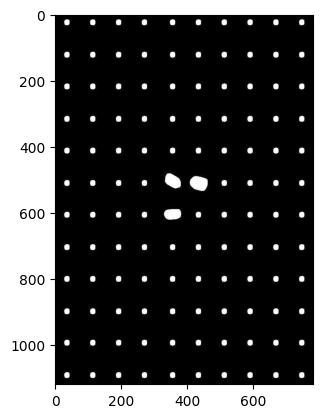

In [2]:
original_image = cv2.imread('images/original/projected.jpg', cv2.IMREAD_GRAYSCALE)
plt.imshow(original_image, cmap='gray')
plt.show()

### Visualization of projected test data

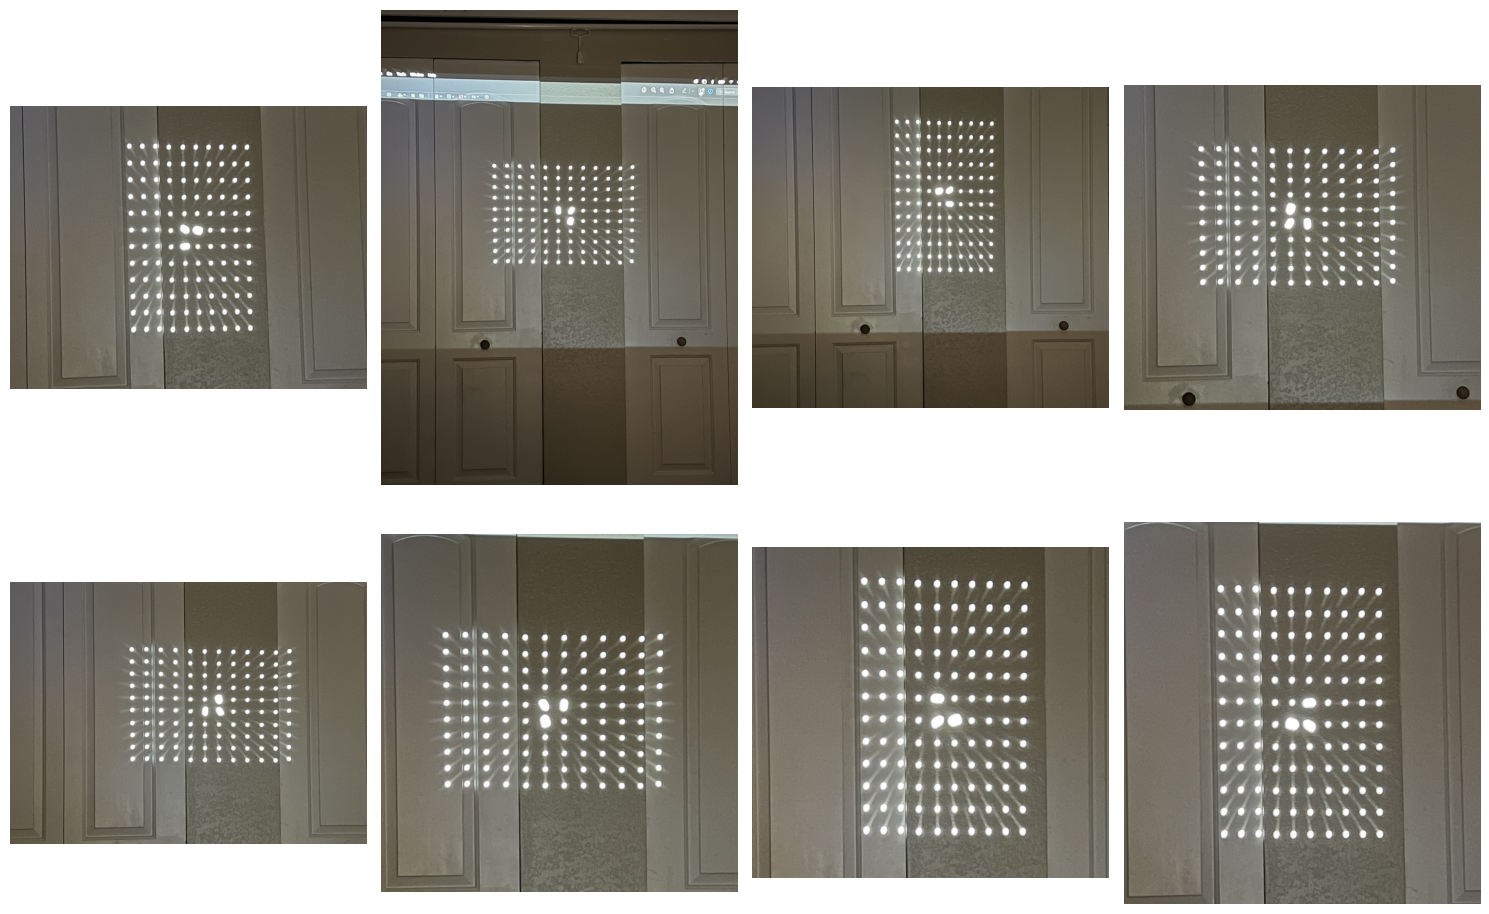

In [3]:

# Get the list of image filenames in the test_images folder
image_folder = 'images/test_images'
image_filenames = [f for f in os.listdir(image_folder) if f.endswith('.jpg')]

# Determine the number of rows and columns for the subplot
num_cols = 4
num_rows = 2

# Create a figure and axes for the subplot
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))

# Flatten the axes array for easy iteration
axs = axs.flatten()

# Loop through the image filenames and display each image
for i, filename in enumerate(image_filenames):
    image_path = os.path.join(image_folder, filename)
    image = plt.imread(image_path)
    axs[i].imshow(image)
    axs[i].axis('off')
    if i == 7:
        break

# Hide any remaining empty subplots
for j in range(i + 1, len(axs)):
    axs[j].axis('off')

plt.tight_layout()
plt.show()

## Image processing 


### Finding the grid within the image
- Note this function requires calibration depending on the pixel distance between grid dots 
see(kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (50, 50)))

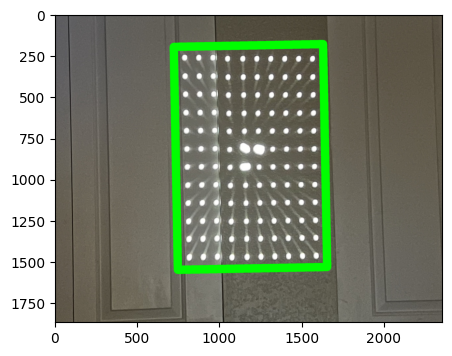

In [4]:
def find_grid(binary):
    """
    Finds the grid in a binary image by detecting contours and fitting a minimum area rectangle.
    Args:
        binary (numpy.ndarray): The binary image in which to find the grid.
    Returns:
        tuple: A tuple containing:
            - box (numpy.ndarray): The corner points of the detected rectangle.
            - angle (float): The rotation angle of the detected rectangle.
            If no rectangle is found, returns (None, None).
    """
    
    # Merge all the dots in order to create a single rectangle contour
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (50, 50)) 
    dilated = cv2.dilate(binary, kernel, iterations=2)
    contours, _ = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Loop through contours to find rectangles
    for contour in contours:
        # Fit a minimum area rectangle
        rect = cv2.minAreaRect(contour)  # Returns (center, (width, height), angle)

        # Check if the rectangle has the correct aspect ratio
        ratio = rect[1][0] / rect[1][1]
        known_ratio = 782 / 1119
        error_rate = 0.1
        #
        if not ((ratio < known_ratio * (1 + error_rate) and ratio > known_ratio * (1 - error_rate)) or (1/ratio < known_ratio * (1 + error_rate) and 1/ratio > known_ratio * (1 - error_rate))):
            continue
        # Get corner points of the rectangle
        box = np.intp(cv2.boxPoints(rect))       
    
        return box , rect[2]
    return None, None



# Test the find_grid function on a sample image

projected_image = cv2.imread('images/test_images/0deg.jpg', cv2.IMREAD_GRAYSCALE)
_, binary = cv2.threshold(projected_image, 190, 255, cv2.THRESH_BINARY)
box, angle = find_grid(binary)
image2 = np.array(plt.imread('images/test_images/0deg.jpg'))
if box is not None:
    plt.figure(figsize=(5, 5))
    cv2.drawContours(image2, [box], 0, (0, 255, 0), 50)
    plt.imshow(image2)
    plt.show()
else:
    print("No grid found")

### Locate and crop the inner identifier 

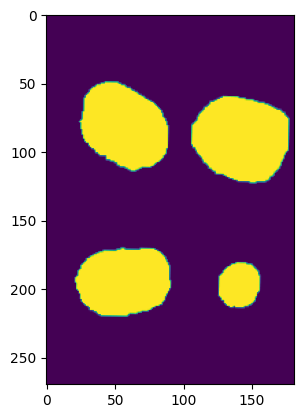

In [5]:
def find_identifier(image,box, angle):
    """
    Finds and crops the identifier region from the image based on the given box and angle.
    Args:
        image (numpy.ndarray): The input image from which to find the identifier.
        box (numpy.ndarray): The corner points of the rectangle.
        angle (float): The rotation angle of the rectangle.
    Returns:
        tuple: A tuple containing:
            - cropped (numpy.ndarray): The cropped identifier region.
            - rotated (bool): A flag indicating if the cropped image was rotated to match template dimensions.
    """
    # Get the image dimensions
    (h, w) = image.shape[:2]

    # Define the center of the image
    center = (w // 2, h // 2)

    # Define the rotation matrix
    M = cv2.getRotationMatrix2D(center, angle, 1.0)

    # Perform the rotation
    rotated = cv2.warpAffine(image, M, (w, h))

    # Rotate the box
    rotated_box = cv2.transform(np.array([box]), M)[0]
    # crop the image to the box
    x, y, w, h = cv2.boundingRect(rotated_box)

    # Crop the image for the identifier
    tl, br = (x+int(w*0.4), y+int(h*0.4)), (x+int(w*0.6), y+int(h*0.6))
    cropped = rotated[tl[1]:br[1], tl[0]:br[0]]

    # rotate the image to match the template dimensions if needed
    rotated = False
    if cropped.shape[0] < cropped.shape[1]:
        rotated = True
        cropped = cv2.rotate(cropped, cv2.ROTATE_90_CLOCKWISE)
        
    return cropped, rotated

cropped, rotated = find_identifier(binary, box, angle)
plt.imshow(cropped)
plt.show()



### Utilize the original template to generate all the variations

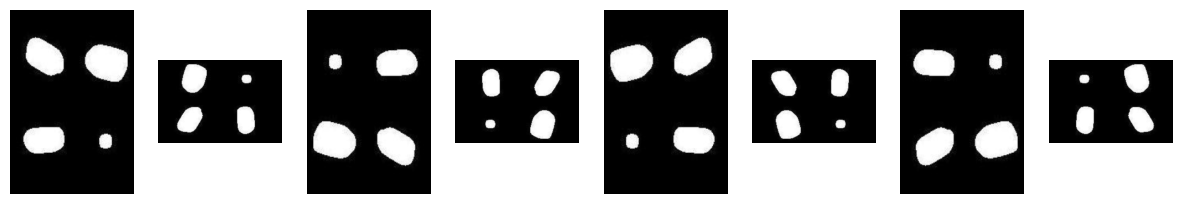

In [6]:
def generate_templates(template):
    """
    Generates a set of templates by rotating and flipping the given template.
    Args:
        template (numpy.ndarray): The input template image.
    Returns:
        list: A list of generated template images.
    """
    templates = []
    for j in [0,1]:
        for i in [0,1,2,3]:
            temp = template.copy()
            if j == 1:
                temp = np.flip(template, 1)
            temp = np.rot90(temp, i)
            templates.append(temp)
    return templates

# Load the template image
template = cv2.imread('images/original/template.jpg', cv2.IMREAD_GRAYSCALE)

# resize the template to match the cropped image
template = cv2.resize(template, (cropped.shape[1], cropped.shape[0]))
templates = generate_templates(template)

# Display the generated templates
fig, axs = plt.subplots(1, 8, figsize=(15, 5))
for i, temp in enumerate(templates):
    axs[i].imshow(temp, cmap='gray')
    axs[i].axis('off')

### Find the closest template to the cropped image and resultant orientation

In [7]:

def find_closest_image(query_image, image_set):
    """
    Finds the closest matching image from a set of images based on the difference score.
    Args:
        query_image (numpy.ndarray): The query image to compare.
        image_set (list of numpy.ndarray): The set of images to compare against.
    Returns:
        int: The index of the closest matching image in the image set.
    """
    # Initialize variables to store the index and score of the closest image
    diff_index = -1
    diff_min_score = float('inf')

   
    for i, target_image in enumerate(image_set):
        # Skip images that are not the same shape
        if query_image.shape != target_image.shape:
            continue
        
        # Calculate the difference score
        diff_score = np.sum(abs(query_image - target_image))
        if diff_score < diff_min_score:
            diff_min_score = diff_score
            diff_index = i

    return diff_index

# Find the closest matching template
index = find_closest_image(cropped, templates)

# map the index to the corresponding angle
if not rotated:
    converter = {0:(0,0),1:(0,270),2:(0,180),3:(0,90),4:(1,0),5:(1,270),6:(1,180),7:(1,90)}
else:
    converter = {0:(0,270),1:(0,180),2:(0,90),3:(0,0),4:(1,270),5:(1,180),6:(1,90),7:(1,0)}

print("The identifier is at angle:", round(converter[index][1]+angle,-1)%360)
print("Image is flipped:", bool(converter[index][0]))

The identifier is at angle: 0.0
Image is flipped: False


### Displaying the images

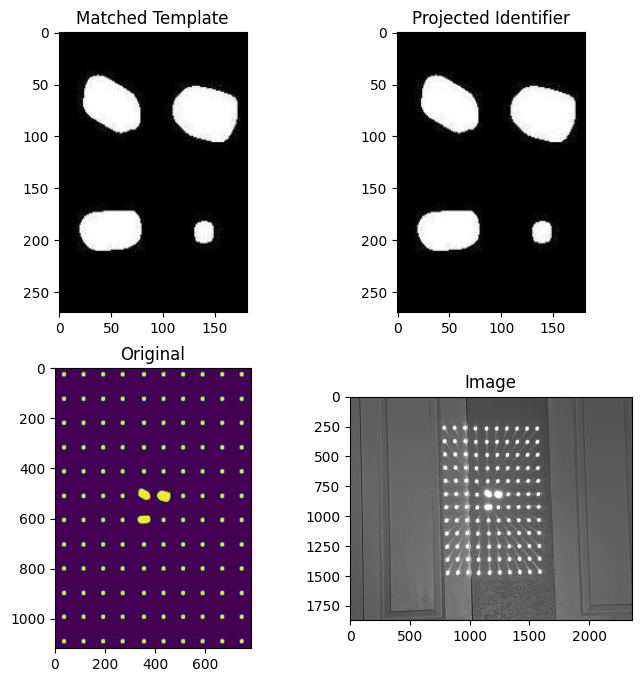

In [8]:
def display(org_image,projected_image, index, templs,comparison):
    """
    Displays the original image, projected image, template image, and segmented image in a 2x2 subplot.
    Args:
        org_image (numpy.ndarray): The original image.
        projected_image (numpy.ndarray): The projected image.
        index (int): The index of the closest matching template image.
        templs (list of numpy.ndarray): The list of template images.
        comparison (numpy.ndarray): The segmented identifier image for comparison.
    Returns:
        None
    """
    fig, axs = plt.subplots(2, 2, figsize=(8, 8))
    # Show the closest match
    axs[0, 0].imshow(templs[index], cmap='gray')
    axs[0, 0].set_title('Matched Template')

    # Show the segmented image
    axs[0, 1].imshow(comparison, cmap='gray')
    axs[0, 1].set_title('Projected Identifier')

    # Show the original image
    axs[1, 0].imshow(projected_image)
    axs[1, 0].set_title('Original')

    # Show the test image
    axs[1, 1].imshow(org_image, cmap='gray')
    axs[1, 1].set_title('Image')

    plt.show()

display(projected_image,original_image,  index, templates, templates[index])

### Combining all the previous parts together and testing

Correct Orientation Found:  (0, 0.0) 0deg.jpg


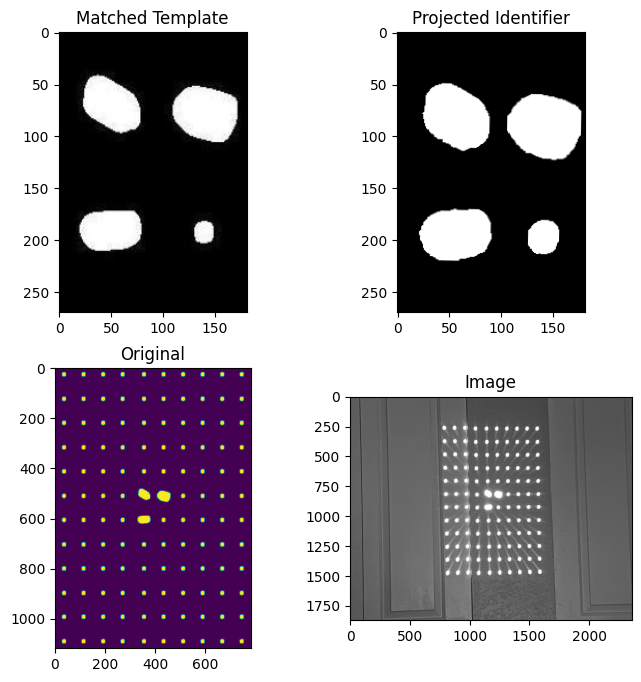

Correct Orientation Found:  (0, 90.0) test2.jpg


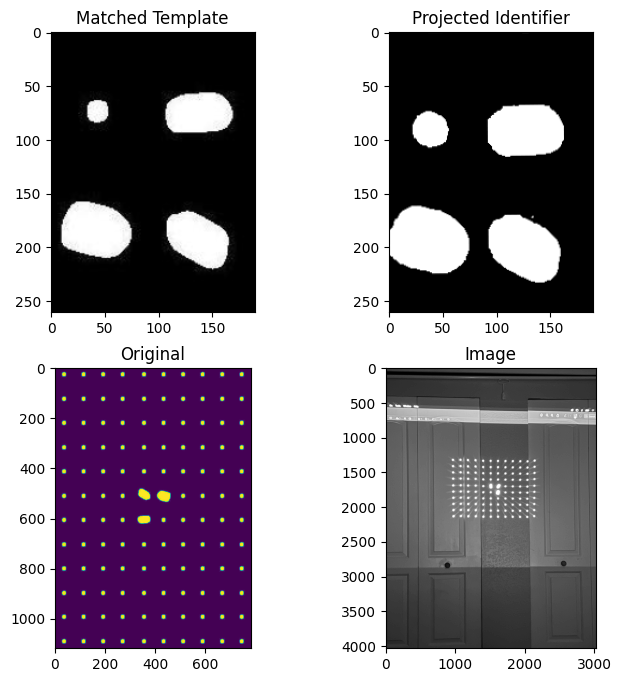

Correct Orientation Found:  (1, 0.0) test.jpg


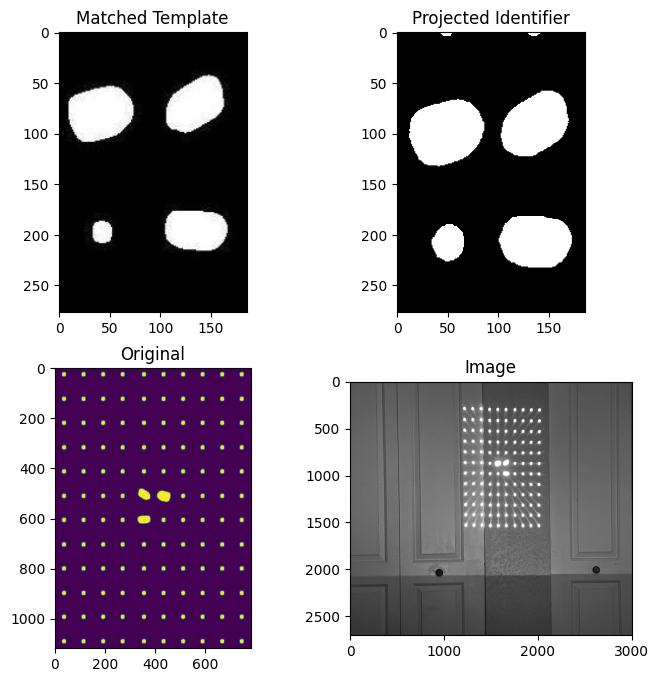

Correct Orientation Found:  (0, 270.0) n90deg.jpg


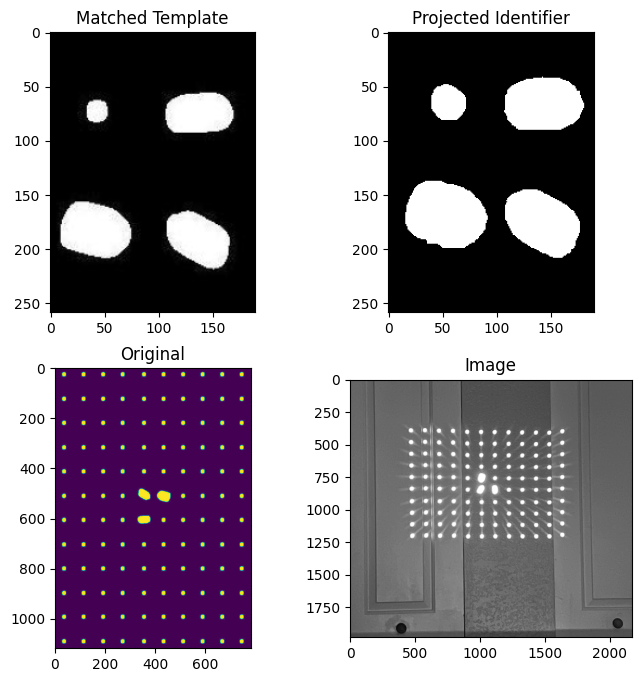

Correct Orientation Found:  (1, 90.0) flip1.jpg


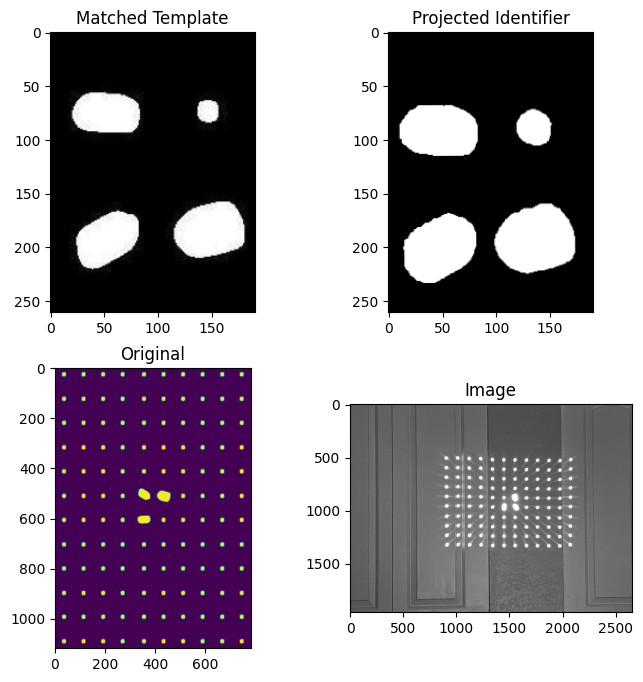

Correct Orientation Found:  (1, 270.0) flip3.jpg


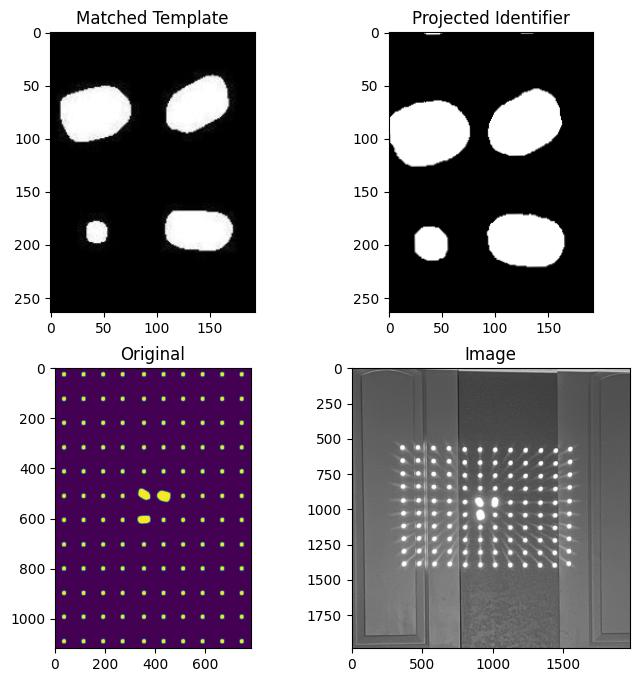

Correct Orientation Found:  (1, 180.0) flip2.jpg


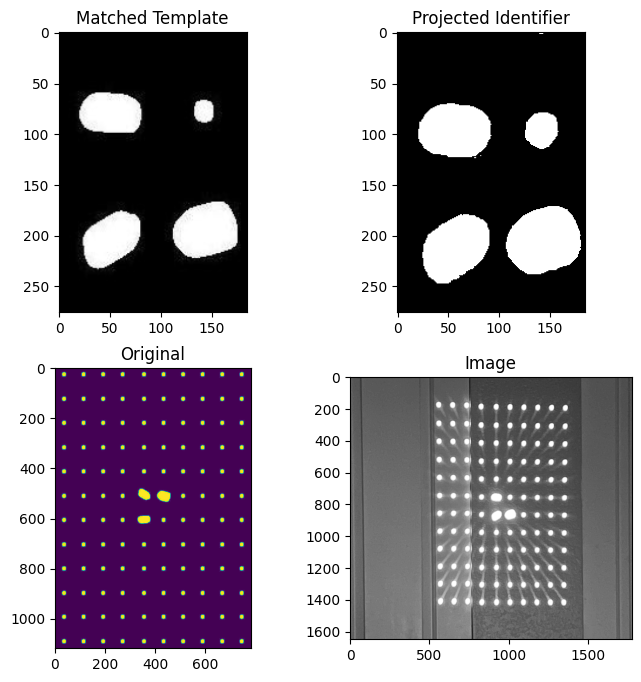

Correct Orientation Found:  (0, 180.0) n180deg.jpg


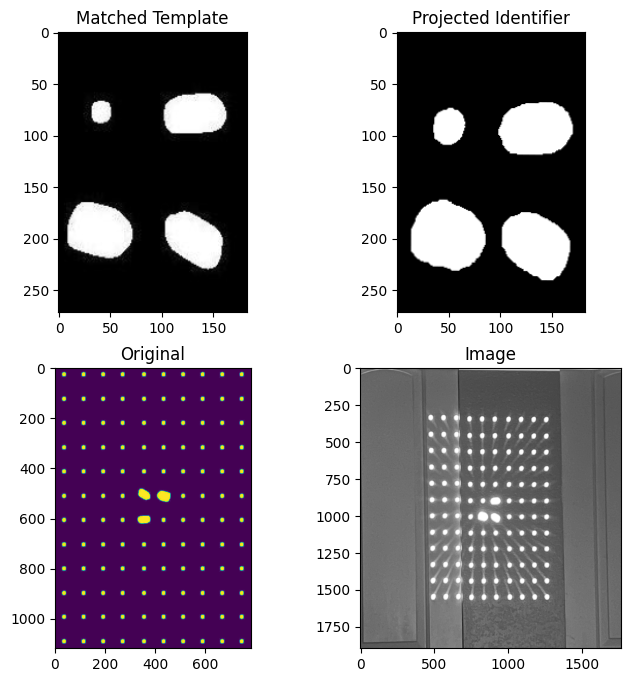

Correct Orientation Found:  (0, 90.0) n270deg.jpg


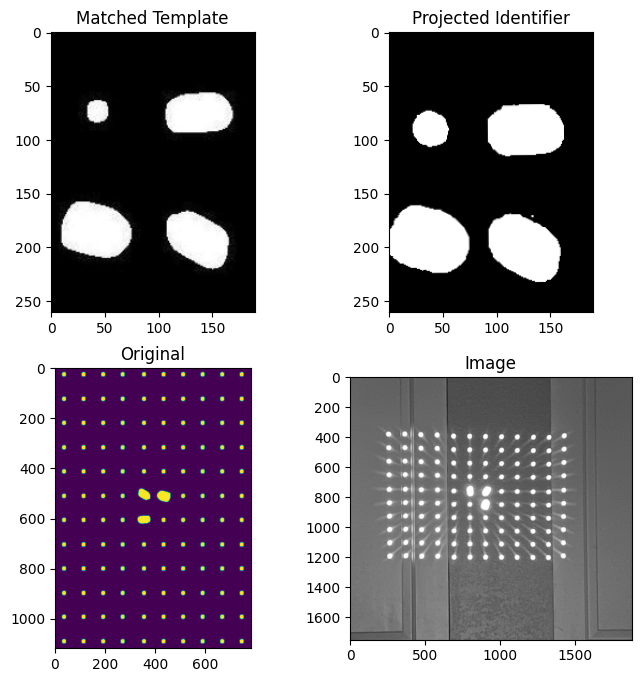

Correct Orientation Found:  (1, 0.0) flip4.jpg


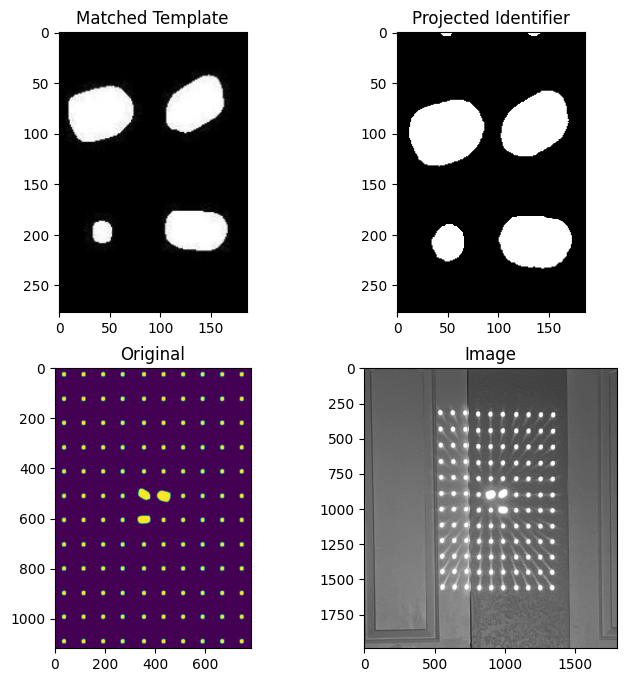

In [9]:
projected_image = cv2.imread('images/original/projected.jpg', cv2.IMREAD_GRAYSCALE)
template = cv2.imread('images/original/template.jpg', cv2.IMREAD_GRAYSCALE)

sol =  {'0deg.jpg':(0,0),'n90deg.jpg':(0,270),'n180deg.jpg':(0,180),'n270deg.jpg':(0,90),
            'test2.jpg':(0, 90),'test.jpg':(1,0),
            'flip1.jpg':(1,90),'flip3.jpg':(1,270),'flip2.jpg':(1,180),'flip4.jpg':(1,0),}


for filename in os.listdir('images/test_images'):
        
    if filename.endswith('.jpg'):
        image = cv2.imread(f'images/test_images/{filename}', cv2.IMREAD_GRAYSCALE)
        _, binary = cv2.threshold(image, 190, 255, cv2.THRESH_BINARY)

        box,box_rot = find_grid(binary)
       
        ident_segment,rotated = find_identifier(binary,box,box_rot)

        # resize the template to the size of the identifier image
        template1 = cv2.resize(template, (ident_segment.shape[1], ident_segment.shape[0]))
        templates = generate_templates(template1)
        
        # (bool flipped, int angle)
        if not rotated:
            converter = {0:(0,0),1:(0,270),2:(0,180),3:(0,90),4:(1,0),5:(1,270),6:(1,180),7:(1,90)}
        else:
            converter = {0:(0,270),1:(0,180),2:(0,90),3:(0,0),4:(1,270),5:(1,180),6:(1,90),7:(1,0)}
            
        min_index = find_closest_image(ident_segment, templates)
        orint = (converter[min_index][0],round((converter[min_index][1]+box_rot),-1)%360)

        if sol[filename] != orint:
            print('Warning mismatched answer: ',filename,sol[filename],orint)
        else:
            print('Correct Orientation Found: ',orint,filename)
        display(image,projected_image, min_index, templates,ident_segment)
        
        